In [10]:
import frgtools.misc as frgm
import frgtools.xrd as xrd
import numpy as np
import matplotlib.pyplot as plt
# from matplotlib import style
# style.use('ggplot') or plt.style.use('ggplot')
import pandas as pd
from scipy.signal import savgol_filter
from scipy.signal import find_peaks_cwt
from tqdm import tqdm
import numpy.ma as ma

In [11]:
# from importlib import reload
# reload(xrd)

<module 'frgtools.xrd' from '/Users/rishi/Documents/GitHub/Python-Utilities/FrgTools/frgtools/xrd.py'>

# Loading Raw Data File

In [12]:
fids = frgm.listdir('Data')

Files in 'Data':
0:KPbF3.ras
1:CsPbSnF3_50_5isl.ras
2:CsPbSnF3_25.ras
3:CsPbF3_AF.ras
4:CsPbSnF3_50.ras
5:KPbF3_fast.ras
6:CsPbF3_B_NK.ras
7:CsPbSnF3_75.ras
8:CsPbSnF3_25_5isl.ras
9:RbPbF3.ras
10:CsPbF3_AF_nK.ras
11:CsPbF3.ras


In [14]:
dfData = {}

for idx, f in enumerate(fids):
    tempdata = xrd.LoadSmartlab(f)
    del(tempdata['header']) #assumes we dont need the header for following analyses
    
    if idx == 0: #on first pass, initialize keys for each data entry in the dataframe dictionary
        for k, v in tempdata.items():
            dfData[k] = [v]
    else:  #on subsequent passes, append new lines of data to dataframe dictionary
        for k, v in tempdata.items():
            dfData[k].append(v)      

df = pd.DataFrame(dfData)

In [15]:
df.head() #.head() only displays the 5 first rows of your dataframe, its a safe way of peeking at the data without rendering a potentially massive table

,name,counts,scanaxis,angles,numscans,scanmode,scanspeed,date,time
0,KPbF3,"[1.0, 0.0, 0.0, 1.0, 2.0, 2.0, 3.0, 1.0, 2.0, ...",Theta/2-Theta,"[10.0, 10.002, 10.004, 10.006, 10.008, 10.01, ...",1,CONTINUOUS,2.40,04/04/19,20:07:40
1,CsPbSnF3_50_5isl,"[7.0, 3.0, 1.0, 8.0, 7.0, 5.0, 7.0, 3.0, 6.0, ...",Theta/2-Theta,"[10.0, 10.01, 10.02, 10.03, 10.04, 10.05, 10.0...",1,CONTINUOUS,3.00,06/05/19,13:57:10
2,CsPbSnF3_25,"[4.0, 8.0, 8.0, 5.0, 5.0, 6.0, 6.0, 5.0, 2.0, ...",Theta/2-Theta,"[10.0, 10.01, 10.02, 10.03, 10.04, 10.05, 10.0...",1,CONTINUOUS,1.50,06/05/19,12:40:13
3,CsPbF3_AF,"[242.0, 244.0, 224.0, 266.0, 238.0, 242.0, 251...",Theta/2-Theta,"[15.0, 15.01, 15.02, 15.03, 15.04, 15.05, 15.0...",1,CONTINUOUS,0.25,07/16/19,13:36:21
4,CsPbSnF3_50,"[3.0, 3.0, 4.0, 2.0, 0.0, 2.0, 2.0, 1.0, 0.0, ...",Theta/2-Theta,"[10.0, 10.01, 10.02, 10.03, 10.04, 10.05, 10.0...",1,CONTINUOUS,3.00,06/05/19,13:18:42


In [25]:
# Filtering out bugged curves (manual entry)
# df = df[df.Name != 'KPbF3_fast']

# plotting a subset of experiment
# filter condition 1:
df_filter1 = df[df.name.str.contains("CsPb")]
# filter condition 2:
df_filter2 = df_filter1[df_filter1.name.str.contains("")]

# # filter condition 3: #1 = reverse, #2 = forward, depends on actual settings when measurement taken
# df_filter3 = df_filter2[df_filter2.Type.str.contains("2")]

df_filter2.reset_index(drop=True, inplace=True)

# list scans in your filtered dataset before plotting
for n in df_filter2['name'].unique(): print(n)

CsPbSnF3_50_5isl
CsPbSnF3_25
CsPbF3_AF
CsPbSnF3_50
CsPbF3_B_NK
CsPbSnF3_75
CsPbSnF3_25_5isl
CsPbF3_AF_nK
CsPbF3


## Looking at selected plots preprocessed

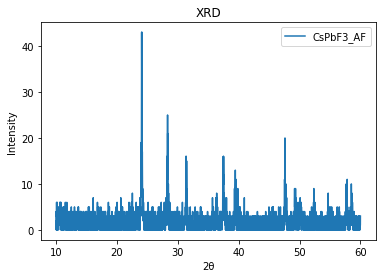

In [29]:
# filtered DataFrame to Plot
DF = df_filter2

# single
q = 3
plt.plot(DF.loc[q]['angles'],DF.loc[q]['counts'], label=Name[q])

# multiple:
# for q in range (0, len(DF), 1):

#     plt.plot(DF.loc[q]['angles'],DF.loc[q]['counts'], label=Name[q])

plt.legend()
plt.title('XRD')
# plt.ylim(0,25)
# plt.xlim(0,1.2)

plt.ylabel('Intensity')
plt.xlabel('2θ')
plt.show()

## Normalizng All XRD Data

In [30]:
def normalizeCounts(x):
    return (x-x.min()) / (x.max() - x.min())
df['counts_norm'] = df['counts'].apply(normalizeCounts) #https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html

## Noise Filtering

REK Note: just need to be careful about smoothing with XRD data. Most (all?) smoothing filters will introduce some level of peak broadening depending on the window length chosen, and peak heights will likely be decreased as well. Potentially risky to include in default preprocessing for refinement, where peak width/heights are crucial. the refinement itself should essentially be peak fitting and compensate for some noise on its own.

In [20]:
from functools import partial #https://docs.python.org/2/library/functools.html

#savgol_filter to smooth the data
df['counts_f1'] = df['counts_norm'].apply(
    partial(savgol_filter, window_length = 31, polyorder = 3)
)

## Peak Indexing

In [21]:
df['peak_index'] = df['counts_f1'].apply(
    partial(find_peaks_cwt, widths = np.arange(10,15), noise_perc = 0.02)
)

In [22]:
def peakAngles(row):
    angles = [row['angles'][idx] for idx in row['peak_index']]
    return np.asarray(angles)

df['peak_angle'] = df.apply(peakAngles, axis = 1)

## Background Subtraction, Re-Normalization, and adding peak Values

Interesting idea, would probably kinda work. A 'more robust' method might be to 

- identify peaks, set all their heights to the average of their neighboring areas (as you've done)
- smooth this new background-only data with savgol
- subtract the smoothed background from the data

In [31]:
window = 12//2 #arbitary guess at width of peaks errors out of window spills over index
                #this can happen if peak is located near end of index
background=[]
for j in range(0, row, 1): #peak angles
    leftofpeak = []
    rightofpeak = []
    for n in range(0, len(df['Peak_Index'][j])):
#         try:
            leftofpeak.append(df['Counts_F1'][j][df['Peak_Index'][j][n]-window])
            rightofpeak.append(df['Counts_F1'][j][df['Peak_Index'][j][n]+window])
        
        
background=['']*len(leftofpeak)

for n in range(0, len(leftofpeak)): # a more robust math function can be used here i guess
    background[n] = np.round((leftofpeak[n] + rightofpeak[n]) / 2,4)

    
for n in tqdm(range(0, row, 1)): #peak index in angle array
    df['Counts_F4'][n] = df['Counts_F1'][n]-background[n]
    df['Counts_F4'][n][df['Counts_F4'][n]< 0] = 0
    df['Counts_F4'][n] = (df['Counts_F4'][n]/ max(df['Counts_F4'][n])).round(3)

for j in range(0, row, 1): #peak angles
    somelist = []
    for n in range(0, len(df['Peak_Index'][j])):
        somelist.append(df['Counts_F4'][j][df['Peak_Index'][j][n]])
#         df['Peak_Intensity'][j] = somelist[n]

        [float(i) for i in somelist]
#         somelist=np.asarray(somelist)
        df.at[j, 'Peak_Intensity'] = somelist
    
for n in range(0, row, 1): 
    df['Peak_Intensity'][n] = np.asarray(df['Peak_Intensity'][n])

NameError: name 'row' is not defined

## Now refinding Peaks after all processing


In [1546]:
# for n in tqdm(range(0, row, 1)): #peak index in angle array
#      df['Peak_Index'][n] = find_peaks_cwt(df['Counts_F4'][n], np.arange(10,15), noise_perc=0.02)

# for j in tqdm(range(0, row, 1)): #peak angles
#     test_list = []
#     for n in range(0, len(df['Peak_Index'][j])):
#         test_list.append(df['Angles'][j][df['Peak_Index'][j][n]])
#         test_list_2 = np.round(test_list,2)
#         [float(i) for i in test_list_2]
#         df.at[j, 'Peak_Angle'] = test_list_2
        
# for n in range(0, row, 1): 
#     df['Peak_Angle'][n] = np.asarray(df['Peak_Angle'][n])
    
# window = 8//2 #arbitary guess at width of peaks errors out of window spills over index
#                 #this can happen if peak is located near end of index
# background=[]
# for j in range(0, row, 1): #peak angles
#     leftofpeak = []
#     rightofpeak = []
#     for n in range(0, len(df['Peak_Index'][j])):
# #         try:
#             leftofpeak.append(df['Counts_F4'][j][df['Peak_Index'][j][n]-window])
#             rightofpeak.append(df['Counts_F4'][j][df['Peak_Index'][j][n]+window])
        
        
# background=['']*len(leftofpeak)

# for n in range(0, len(leftofpeak)): # a more robust math function can be used here i guess
#     background[n] = np.round((leftofpeak[n] + rightofpeak[n]) / 2,4)

    
# for n in tqdm(range(0, row, 1)): #peak index in angle array
#     df['Counts_F4'][n] = df['Counts_F4'][n]-background[n]
#     df['Counts_F4'][n][df['Counts_F4'][n]< 0] = 0
#     df['Counts_F4'][n] = (df['Counts_F4'][n]/ max(df['Counts_F4'][0])).round(3)

# for j in range(0, row, 1): #peak angles
#     somelist = []
#     for n in range(0, len(df['Peak_Index'][j])):
#         somelist.append(df['Counts_F4'][j][df['Peak_Index'][j][n]])
# #         df['Peak_Intensity'][j] = somelist[n]

#         [float(i) for i in somelist]
# #         somelist=np.asarray(somelist)
#         df.at[j, 'Peak_Intensity'] = somelist
    
# for n in range(0, row, 1): 
#     df['Peak_Intensity'][n] = np.asarray(df['Peak_Intensity'][n])

### Checking background sum value: need to write a fx to minimize on this value

In [1547]:
background
total=0
for n in range(0, len(background)): 
    total = total + background[n]
total

2.5585

### Now Refiltering to Interested Samples

In [1548]:
df_filter1 = df[df.Name.str.contains("CsPb")]
# filter condition 2:
df_filter2 = df_filter1[df_filter1.Name.str.contains("")]

# # filter condition 3: #1 = reverse, #2 = forward, depends on actual settings when measurement taken
# df_filter3 = df_filter2[df_filter2.Type.str.contains("2")]

df_filter2.reset_index(drop=True, inplace=True)

# observing your dataset before plotting
df_filter2

,Name,Date,Time,Type,Scan_Mode,Alpha_1,Alpha_2,Beta_1,Current,Voltage,...,Start,Stop,Angles,Counts_Raw,Counts_Norm,Counts_F1,Peak_Index,Peak_Angle,Counts_F4,Peak_Intensity
0,CsPbF3_AF_nK,07/16/19,18:40:43,Bragg-Brentano focusing,CONTINUOUS,1.54059,1.54441,1.39225,30,40,...,15,90,"[15.0, 15.01, 15.02, 15.03, 15.04, 15.05, 15.0...","[3.0, 2.0, 3.0, 4.0, 4.0, 4.0, 1.0, 1.0, 4.0, ...","[0.026, 0.017, 0.026, 0.035, 0.035, 0.035, 0.0...","[0.025, 0.024, 0.024, 0.025, 0.025, 0.025, 0.0...","[14, 350, 1129, 1743, 2249, 2709, 3132, 3899, ...","[15.14, 18.5, 26.29, 32.43, 37.49, 42.09, 46.3...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.031, 1.0, 0.0, 0.289, 0.012, 0.433, 0...."
1,CsPbF3_AF,07/16/19,13:36:21,Bragg-Brentano focusing,CONTINUOUS,1.54059,1.54441,1.39225,30,40,...,15,90,"[15.0, 15.01, 15.02, 15.03, 15.04, 15.05, 15.0...","[242.0, 244.0, 224.0, 266.0, 238.0, 242.0, 251...","[0.367, 0.37, 0.34, 0.404, 0.361, 0.367, 0.381...","[0.372, 0.37, 0.369, 0.369, 0.368, 0.368, 0.36...","[10, 345, 1114, 1466, 2237, 2696, 2750, 3117, ...","[15.1, 18.45, 26.14, 29.66, 37.37, 41.96, 42.5...","[0.358, 0.356, 0.354, 0.354, 0.353, 0.353, 0.3...","[0.359, 0.475, 1.0, 0.17, 0.292, 0.051, 0.058,..."
2,CsPbF3_B_NK,05/02/19,12:27:26,Bragg-Brentano focusing,CONTINUOUS,1.54059,1.54441,1.39225,30,40,...,10,90,"[10.0, 10.01, 10.02, 10.03, 10.04, 10.05, 10.0...","[4.0, 8.0, 4.0, 5.0, 6.0, 3.0, 6.0, 7.0, 5.0, ...","[0.029, 0.058, 0.029, 0.036, 0.043, 0.022, 0.0...","[0.032, 0.035, 0.037, 0.039, 0.041, 0.043, 0.0...","[11, 92, 236, 855, 1379, 1631, 2470, 2751, 321...","[10.11, 10.92, 12.36, 18.55, 23.79, 26.31, 34....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.001, 0.0..."
3,CsPbF3,04/04/19,12:32:03,Bragg-Brentano focusing,CONTINUOUS,1.54059,1.54441,1.39225,30,40,...,10,90,"[10.0, 10.01, 10.02, 10.03, 10.04, 10.05, 10.0...","[1.0, 2.0, 3.0, 3.0, 0.0, 3.0, 0.0, 1.0, 3.0, ...","[0.016, 0.033, 0.049, 0.049, 0.0, 0.049, 0.0, ...","[0.028, 0.029, 0.029, 0.029, 0.03, 0.03, 0.03,...","[32, 94, 849, 1151, 1626, 1990, 2747, 3209, 36...","[10.32, 10.94, 18.49, 21.51, 26.26, 29.9, 37.4...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.084, 0.0, 1.0, 0.003, 0.731, 0.01..."
4,CsPbSnF3_25_5isl,06/05/19,14:15:35,Bragg-Brentano focusing,CONTINUOUS,1.54059,1.54441,1.39225,30,40,...,10,60,"[10.0, 10.01, 10.02, 10.03, 10.04, 10.05, 10.0...","[7.0, 3.0, 4.0, 6.0, 6.0, 2.0, 9.0, 5.0, 6.0, ...","[0.091, 0.039, 0.052, 0.078, 0.078, 0.026, 0.1...","[0.061, 0.064, 0.066, 0.069, 0.072, 0.075, 0.0...","[14, 151, 407, 906, 1406, 1716, 1926, 2134, 23...","[10.14, 11.51, 14.07, 19.06, 24.06, 27.16, 29....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.717, 0.879, 1.0, 0.372,..."
5,CsPbSnF3_25,06/05/19,12:40:13,Bragg-Brentano focusing,CONTINUOUS,1.54059,1.54441,1.39225,30,40,...,10,60,"[10.0, 10.01, 10.02, 10.03, 10.04, 10.05, 10.0...","[4.0, 8.0, 8.0, 5.0, 5.0, 6.0, 6.0, 5.0, 2.0, ...","[0.038, 0.076, 0.076, 0.048, 0.048, 0.057, 0.0...","[0.057, 0.057, 0.056, 0.055, 0.054, 0.054, 0.0...","[9, 551, 854, 1201, 1407, 1652, 1830, 2136, 26...","[10.09, 15.51, 18.54, 22.01, 24.07, 26.52, 28....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.004, 0.0, 0.329, 1.0, 0.212, 0.25..."
6,CsPbSnF3_50_5isl,06/05/19,13:57:10,Bragg-Brentano focusing,CONTINUOUS,1.54059,1.54441,1.39225,30,40,...,10,60,"[10.0, 10.01, 10.02, 10.03, 10.04, 10.05, 10.0...","[7.0, 3.0, 1.0, 8.0, 7.0, 5.0, 7.0, 3.0, 6.0, ...","[0.083, 0.036, 0.012, 0.095, 0.083, 0.06, 0.08...","[0.06, 0.06, 0.061, 0.061, 0.061, 0.06, 0.06, ...","[10, 88, 368, 913, 969, 1408, 1833, 2138, 2750...","[10.1, 10.88, 13.68, 19.13, 19.69, 24.08, 28.3...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.017, 0.0, 0.0..."
7,CsPbSnF3_50,06/05/19,13:18:42,Bragg-Brentano focusing,CONTINUOUS,1.54059,1.54441,1.39225,30,40,...,10,60,"[10.0, 10.01, 10.02, 10.03, 10.04, 10.05, 10.0...","[3.

### Now Plotting Processed Data

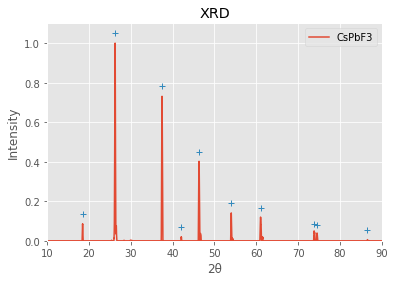

In [1549]:
# filtered DataFrame to Plot
DF = df_filter2

# plotting single use:
q = 3
#masking out bad peaks
a = DF['Peak_Intensity'][q]
a = np.ma.masked_where(a <= 0.005 , a)

#plotting
plt.plot(DF.loc[q]['Angles'],DF.loc[q]['Counts_F4'], label=Name[q])
plt.plot(DF['Peak_Angle'][q],a+.05,'+')

# plotting multiple use:
# for q in range (0, len(DF), 1):
#     #masking out bad peaks
#     a = DF['Peak_Intensity'][q]
#     a = np.ma.masked_where(a <= 0.005 , a)
    
#     #plotting
#     plt.plot(DF.loc[q]['Angles'],DF.loc[q]['Counts_F4'], label=Name[q])
#     plt.plot(DF['Peak_Angle'][q],a+.05,'+',label=Name[q])


plt.legend()
plt.title('XRD')
plt.ylim(0,1.1)
plt.xlim(min(DF.loc[q]['Angles']),max(DF.loc[q]['Angles']))

plt.ylabel('Intensity')
plt.xlabel('2θ')
plt.show()